### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
    Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees, identify right error metrics.

### Data Pre-processing
#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf

from keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import Callback
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Using TensorFlow backend.


###### fix random seed for reproducibility

    Generally, Keras gets its source of randomness from the NumPy random number generator.
    
    In addition, TensorFlow has its own random number generator that must also be seeded by calling the set_random_seed() function immediately after the NumPy random number generator, as follows:

In [2]:
np.random.seed(123)

tf.set_random_seed(123)

Get current working directory

In [3]:
PATH = os.getcwd()

Change directory

In [4]:
os.chdir(PATH)

#### Loading the data

In [5]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the number row and columns

In [6]:
data.shape

(61589, 23)

Display the columns

In [7]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [8]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [9]:
data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe.

    For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. 

        The top is the most common value.

        The freq is the most common value’s frequency.

In [10]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [11]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 

    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [12]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [13]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

##### Delete sku attribute

In [14]:
np.size(np.unique(data.sku))

61589

In [15]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [16]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [17]:
print (data.shape)

(61589, 22)


Since the number of missing values is about 5%. For initial analysis we ignore all these records

In [18]:
data = data.dropna(axis=0)

In [19]:
print(data.isnull().sum())
print("----------------------------------")
print(data.shape)

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64
----------------------------------
(58186, 22)


#### Converting Categorical to Numeric

For some of the models all the independent attribute should be of type numeric and ANN model is one among them.
But this data set has some categorial attributes.

'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [20]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


##### Creating dummy variables.

If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [21]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [22]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, prefix=categorical_Attributes, prefix_sep="_",drop_first=True)

In [23]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Target attribute distribution

In [24]:
pd.value_counts(data['went_on_backorder_Yes'])

0    47217
1    10969
Name: went_on_backorder_Yes, dtype: int64

In [25]:
pd.value_counts(data['went_on_backorder_Yes'])/data['went_on_backorder_Yes'].count() * 100

0    81.148386
1    18.851614
Name: went_on_backorder_Yes, dtype: float64

#### Train-Test Split

Using sklearn.model_selection.train_test_split

    Split arrays or matrices into train and test subsets

In [26]:
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = data['went_on_backorder_Yes'])

In [27]:
print(X_train.shape)
print(X_test.shape)

(40730, 21)
(17456, 21)


In [28]:
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33052
1     7678
dtype: int64
0    14165
1     3291
dtype: int64


In [29]:
print(pd.value_counts(y_train)/y_train.size * 100)
print(pd.value_counts(y_test)/y_test.size * 100)

0    81.14903
1    18.85097
dtype: float64
0    81.146884
1    18.853116
dtype: float64


### Perceptron Model

In [30]:
np.random.seed(123)

tf.set_random_seed(123)

In [31]:
perceptron_model = Sequential()

perceptron_model.add(Dense(1, input_dim=21, activation='sigmoid', kernel_initializer='normal'))

In [32]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [33]:
perceptron_model_history = perceptron_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 16us/step - loss: 2.5261 - acc: 0.8107 - val_loss: 3.0792 - val_acc: 0.8048
Epoch 2/100
32584/32584 [==============================] - 0s 14us/step - loss: 2.9351 - acc: 0.8129 - val_loss: 3.0778 - val_acc: 0.8048
Epoch 3/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9333 - acc: 0.8130 - val_loss: 3.0757 - val_acc: 0.8048
Epoch 4/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9313 - acc: 0.8129 - val_loss: 3.0739 - val_acc: 0.8048
Epoch 5/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9290 - acc: 0.8129 - val_loss: 3.0718 - val_acc: 0.8048
Epoch 6/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9263 - acc: 0.8130 - val_loss: 3.0687 - val_acc: 0.8048
Epoch 7/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9228 - acc: 0.8130 - val_loss: 3.0661 - v

32584/32584 [==============================] - 0s 12us/step - loss: 2.9768 - acc: 0.8127 - val_loss: 3.1141 - val_acc: 0.8042
Epoch 60/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9767 - acc: 0.8127 - val_loss: 3.1142 - val_acc: 0.8042
Epoch 61/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9767 - acc: 0.8128 - val_loss: 3.1143 - val_acc: 0.8042
Epoch 62/100
32584/32584 [==============================] - 0s 11us/step - loss: 2.9767 - acc: 0.8127 - val_loss: 3.1140 - val_acc: 0.8042
Epoch 63/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9765 - acc: 0.8128 - val_loss: 3.1142 - val_acc: 0.8041
Epoch 64/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9766 - acc: 0.8128 - val_loss: 3.1138 - val_acc: 0.8042
Epoch 65/100
32584/32584 [==============================] - 0s 12us/step - loss: 2.9765 - acc: 0.8127 - val_loss: 3.1141 - val_acc: 0.8041
Epoch 66/100
32584/32584 [==============

##### Plot

In [34]:
print(perceptron_model_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


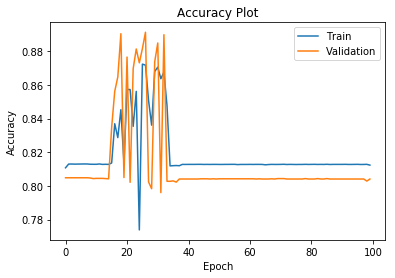

In [35]:
plt.plot(perceptron_model_history.history['acc'])
plt.plot(perceptron_model_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

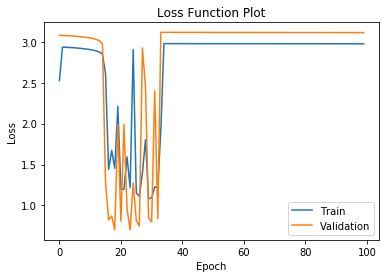

In [36]:
plt.plot(perceptron_model_history.history['loss'])
plt.plot(perceptron_model_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

##### Predictions

In [37]:
test_pred = perceptron_model.predict_classes(X_test)
train_pred = perceptron_model.predict_classes(X_train)

confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32997    55]
 [ 7641    37]]
[[14125    40]
 [ 3281    10]]


##### Train Test Accuracy, True Negative Rate and True Positive Rate

In [38]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

print("-----------------------")

Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Train TNR:  0.9983359554641171
Train TPR:  0.004818963271685335
Train Accuracy:  0.8110483672968328
-----------------------
Test TNR:  0.9971761383692199
Test TPR:  0.003038590094196293
Test Accuracy:  0.809750229147571


### MLP with 2 layers

    1 hidden layer with 15 neurons

In [39]:
np.random.seed(123)

tf.set_random_seed(123)

In [40]:
mlp_model1 = Sequential()

mlp_model1.add(Dense(15, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model1.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [41]:
mlp_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 346
Trainable params: 346
Non-trainable params: 0
_________________________________________________________________


In [42]:
mlp_model1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [43]:
model1_history = mlp_model1.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 18us/step - loss: 0.3763 - acc: 0.8324 - val_loss: 0.3233 - val_acc: 0.8493
Epoch 2/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.3039 - acc: 0.8584 - val_loss: 0.2829 - val_acc: 0.8820
Epoch 3/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2945 - acc: 0.8619 - val_loss: 0.2931 - val_acc: 0.8763
Epoch 4/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2925 - acc: 0.8634 - val_loss: 0.3127 - val_acc: 0.8413
Epoch 5/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2934 - acc: 0.8682 - val_loss: 0.2823 - val_acc: 0.8777
Epoch 6/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2873 - acc: 0.8761 - val_loss: 0.2824 - val_acc: 0.8856
Epoch 7/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2765 - acc: 0.8841 - val_loss: 0.2950 - v

32584/32584 [==============================] - 0s 14us/step - loss: 0.2798 - acc: 0.8846 - val_loss: 0.2905 - val_acc: 0.8783
Epoch 60/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2823 - acc: 0.8883 - val_loss: 0.2857 - val_acc: 0.8824
Epoch 61/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2859 - acc: 0.8825 - val_loss: 0.2787 - val_acc: 0.8887
Epoch 62/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2754 - acc: 0.8886 - val_loss: 0.2796 - val_acc: 0.8860
Epoch 63/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2828 - acc: 0.8830 - val_loss: 0.2784 - val_acc: 0.8842
Epoch 64/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2792 - acc: 0.8849 - val_loss: 0.2767 - val_acc: 0.8880
Epoch 65/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2743 - acc: 0.8867 - val_loss: 0.2799 - val_acc: 0.8793
Epoch 66/100
32584/32584 [==============

##### Plot

In [44]:
print(model1_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


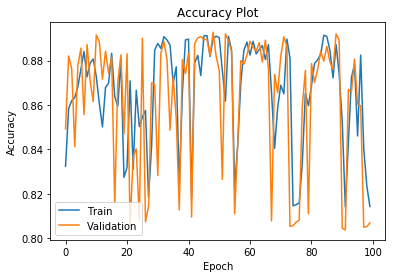

In [45]:
plt.plot(model1_history.history['acc'])
plt.plot(model1_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

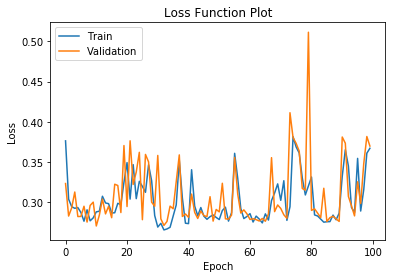

In [46]:
plt.plot(model1_history.history['loss'])
plt.plot(model1_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [47]:
train_model1_pred = mlp_model1.predict_classes(X_train)
test_model1_pred = mlp_model1.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [48]:
confusion_matrix_train = confusion_matrix(y_train, train_model1_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model1_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32896   156]
 [ 7447   231]]
[[14079    86]
 [ 3184   107]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [49]:
Accuracy_Train_M1 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M1 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M1 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M1)
print("Train TPR: ",TPR_Train_M1)
print("Train Accuracy: ",Accuracy_Train_M1)

print("-----------------------")

Accuracy_Test_M1 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M1)
print("Test TPR: ",TPR_Test_M1)
print("Test Accuracy: ",Accuracy_Test_M1)

Train TNR:  0.9952801645891323
Train TPR:  0.03008595988538682
Train Accuracy:  0.8133316965381783
-----------------------
Test TNR:  0.9939286974938228
Test TPR:  0.03251291400790034
Test Accuracy:  0.8126718606782768


### MLP with 2 layers

    1 hidden layer with 20 neurons

In [50]:
np.random.seed(123)

tf.set_random_seed(123)

In [51]:
mlp_model2 = Sequential()

mlp_model2.add(Dense(20, input_dim=21, activation='sigmoid', kernel_initializer='normal'))
mlp_model2.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [52]:
mlp_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                440       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [53]:
mlp_model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [54]:
model2_history = mlp_model2.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 18us/step - loss: 0.4064 - acc: 0.8128 - val_loss: 0.3527 - val_acc: 0.8208
Epoch 2/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.3269 - acc: 0.8405 - val_loss: 0.3121 - val_acc: 0.8591
Epoch 3/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2987 - acc: 0.8643 - val_loss: 0.2937 - val_acc: 0.8712
Epoch 4/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2826 - acc: 0.8805 - val_loss: 0.2871 - val_acc: 0.8744
Epoch 5/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2749 - acc: 0.8855 - val_loss: 0.2773 - val_acc: 0.8822
Epoch 6/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2696 - acc: 0.8877 - val_loss: 0.2722 - val_acc: 0.8822
Epoch 7/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2742 - acc: 0.8842 - val_loss: 0.2759 - v

32584/32584 [==============================] - 0s 13us/step - loss: 0.2545 - acc: 0.8914 - val_loss: 0.2558 - val_acc: 0.8922
Epoch 60/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2594 - acc: 0.8919 - val_loss: 0.2585 - val_acc: 0.8898
Epoch 61/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2550 - acc: 0.8945 - val_loss: 0.2766 - val_acc: 0.8793
Epoch 62/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2987 - acc: 0.8719 - val_loss: 0.3119 - val_acc: 0.8819
Epoch 63/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2849 - acc: 0.8862 - val_loss: 0.2676 - val_acc: 0.8948
Epoch 64/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2630 - acc: 0.8893 - val_loss: 0.2666 - val_acc: 0.8852
Epoch 65/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2608 - acc: 0.8916 - val_loss: 0.2655 - val_acc: 0.8828
Epoch 66/100
32584/32584 [==============

##### Plot

In [55]:
print(model2_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


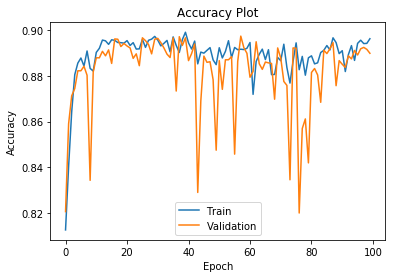

In [56]:
plt.plot(model2_history.history['acc'])
plt.plot(model2_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

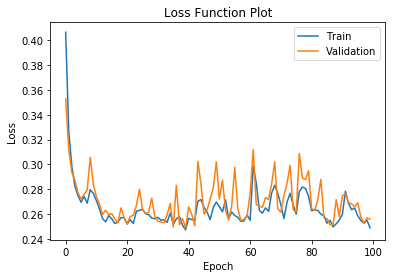

In [57]:
plt.plot(model2_history.history['loss'])
plt.plot(model2_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [58]:
train_model2_pred = mlp_model2.predict_classes(X_train)
test_model2_pred = mlp_model2.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [59]:
confusion_matrix_train = confusion_matrix(y_train, train_model2_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model2_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30451  2601]
 [ 1742  5936]]
[[13022  1143]
 [  779  2512]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [60]:
Accuracy_Train_M2 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M2 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M2 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M2)
print("Train TPR: ",TPR_Train_M2)
print("Train Accuracy: ",Accuracy_Train_M2)

print("-----------------------")

Accuracy_Test_M2 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M2 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M2 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M2)
print("Test TPR: ",TPR_Test_M2)
print("Test Accuracy: ",Accuracy_Test_M2)

Train TNR:  0.9213058211303401
Train TPR:  0.773117999479031
Train Accuracy:  0.8933709796219004
-----------------------
Test TNR:  0.9193081539004588
Test TPR:  0.7632938316621087
Test Accuracy:  0.8898945921173236


### MLP with 2 layers

    1 hidden layer with 25 neurons

In [61]:
np.random.seed(123)

tf.set_random_seed(123)

In [62]:
mlp_model3 = Sequential()

mlp_model3.add(Dense(25, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model3.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [63]:
mlp_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 25)                550       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________


In [64]:
mlp_model3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [65]:
model3_history = mlp_model3.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 19us/step - loss: 0.3369 - acc: 0.8575 - val_loss: 0.2981 - val_acc: 0.8738
Epoch 2/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2865 - acc: 0.8748 - val_loss: 0.2990 - val_acc: 0.8799
Epoch 3/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2745 - acc: 0.8847 - val_loss: 0.2691 - val_acc: 0.8839
Epoch 4/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2734 - acc: 0.8818 - val_loss: 0.2729 - val_acc: 0.8876
Epoch 5/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2726 - acc: 0.8835 - val_loss: 0.2756 - val_acc: 0.8835
Epoch 6/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2749 - acc: 0.8808 - val_loss: 0.2892 - val_acc: 0.8765
Epoch 7/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2838 - acc: 0.8729 - val_loss: 0.3711 - v

32584/32584 [==============================] - 0s 13us/step - loss: 0.3664 - acc: 0.8277 - val_loss: 0.3772 - val_acc: 0.8118
Epoch 60/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.3288 - acc: 0.8527 - val_loss: 0.2927 - val_acc: 0.8846
Epoch 61/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.2890 - acc: 0.8810 - val_loss: 0.2834 - val_acc: 0.8879
Epoch 62/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.3085 - acc: 0.8578 - val_loss: 0.3213 - val_acc: 0.8246
Epoch 63/100
32584/32584 [==============================] - 0s 13us/step - loss: 0.3134 - acc: 0.8430 - val_loss: 0.3287 - val_acc: 0.8057
Epoch 64/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.3063 - acc: 0.8527 - val_loss: 0.2751 - val_acc: 0.8777
Epoch 65/100
32584/32584 [==============================] - 0s 14us/step - loss: 0.2894 - acc: 0.8678 - val_loss: 0.2838 - val_acc: 0.8840
Epoch 66/100
32584/32584 [==============

##### Plot

In [66]:
print(model3_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


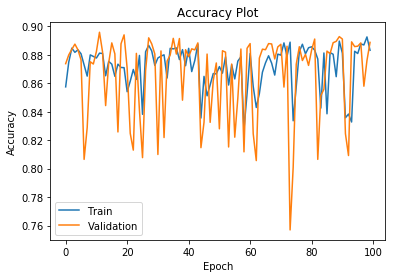

In [67]:
plt.plot(model3_history.history['acc'])
plt.plot(model3_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

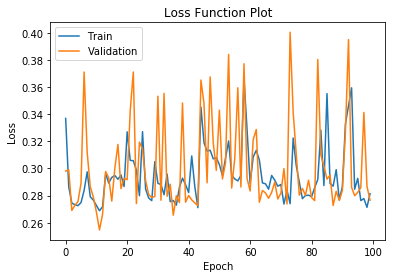

In [68]:
plt.plot(model3_history.history['loss'])
plt.plot(model3_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [69]:
train_model3_pred = mlp_model3.predict_classes(X_train)
test_model3_pred = mlp_model3.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [70]:
confusion_matrix_train = confusion_matrix(y_train, train_model3_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model3_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30649  2403]
 [ 1979  5699]]
[[13117  1048]
 [  878  2413]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [71]:
Accuracy_Train_M3 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M3 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M3 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M3)
print("Train TPR: ",TPR_Train_M3)
print("Train Accuracy: ",Accuracy_Train_M3)

print("-----------------------")

Accuracy_Test_M3 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M3 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M3 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M3)
print("Test TPR: ",TPR_Test_M3)
print("Test Accuracy: ",Accuracy_Test_M3)

Train TNR:  0.9272963814595183
Train TPR:  0.7422505860901276
Train Accuracy:  0.8924134544561748
-----------------------
Test TNR:  0.9260148252735616
Test TPR:  0.7332117897295655
Test Accuracy:  0.8896654445462878


Observation:

    Based on the TPR, 2 layer MLP with 25 nodes hidden layer is best

### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 15 neurons

In [72]:
np.random.seed(123)

tf.set_random_seed(123)

In [73]:
mlp_model4 = Sequential()

mlp_model4.add(Dense(25, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model4.add(Dense(15, activation='tanh', kernel_initializer='normal'))
mlp_model4.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [74]:
mlp_model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 25)                550       
_________________________________________________________________
dense_9 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [75]:
mlp_model4.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [76]:
model4_history = mlp_model4.fit(X_train, y_train, epochs=150, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/150
32584/32584 [==============================] - 1s 21us/step - loss: 0.4592 - acc: 0.8170 - val_loss: 0.3302 - val_acc: 0.8560
Epoch 2/150
32584/32584 [==============================] - 0s 15us/step - loss: 0.2918 - acc: 0.8770 - val_loss: 0.2724 - val_acc: 0.8887
Epoch 3/150
32584/32584 [==============================] - 0s 15us/step - loss: 0.2785 - acc: 0.8826 - val_loss: 0.3290 - val_acc: 0.8193
Epoch 4/150
32584/32584 [==============================] - 0s 15us/step - loss: 0.2787 - acc: 0.8779 - val_loss: 0.2731 - val_acc: 0.8918
Epoch 5/150
32584/32584 [==============================] - 0s 15us/step - loss: 0.2720 - acc: 0.8851 - val_loss: 0.2731 - val_acc: 0.8831
Epoch 6/150
32584/32584 [==============================] - 0s 15us/step - loss: 0.2719 - acc: 0.8824 - val_loss: 0.2695 - val_acc: 0.8868
Epoch 7/150
32584/32584 [==============================] - 0s 15us/step - loss: 0.2763 - acc: 0.8793 - val_loss: 0.2928 - v

32584/32584 [==============================] - 0s 15us/step - loss: 0.2849 - acc: 0.8789 - val_loss: 0.2789 - val_acc: 0.8764
Epoch 60/150
32584/32584 [==============================] - 0s 15us/step - loss: 0.2794 - acc: 0.8829 - val_loss: 0.2724 - val_acc: 0.8889
Epoch 61/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.3053 - acc: 0.8713 - val_loss: 0.2774 - val_acc: 0.8786
Epoch 62/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.2987 - acc: 0.8684 - val_loss: 0.2730 - val_acc: 0.8849
Epoch 63/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.3292 - acc: 0.8326 - val_loss: 0.3142 - val_acc: 0.8469
Epoch 64/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.3013 - acc: 0.8605 - val_loss: 0.2834 - val_acc: 0.8766
Epoch 65/150
32584/32584 [==============================] - 0s 15us/step - loss: 0.2775 - acc: 0.8785 - val_loss: 0.2846 - val_acc: 0.8782
Epoch 66/150
32584/32584 [==============

Epoch 118/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.2980 - acc: 0.8718 - val_loss: 0.3281 - val_acc: 0.8382
Epoch 119/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.2825 - acc: 0.8803 - val_loss: 0.2744 - val_acc: 0.8871
Epoch 120/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.2669 - acc: 0.8935 - val_loss: 0.2718 - val_acc: 0.8889
Epoch 121/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.2824 - acc: 0.8734 - val_loss: 0.2827 - val_acc: 0.8791
Epoch 122/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.2777 - acc: 0.8845 - val_loss: 0.2781 - val_acc: 0.8840
Epoch 123/150
32584/32584 [==============================] - 0s 14us/step - loss: 0.2798 - acc: 0.8773 - val_loss: 0.2936 - val_acc: 0.8570
Epoch 124/150
32584/32584 [==============================] - 0s 15us/step - loss: 0.2797 - acc: 0.8841 - val_loss: 0.3263 - val_acc: 0.8171
Epoch 125/150
32584/

##### Plot

In [77]:
print(model4_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


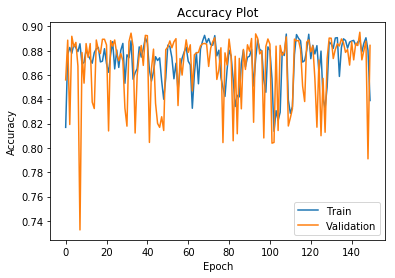

In [78]:
plt.plot(model4_history.history['acc'])
plt.plot(model4_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

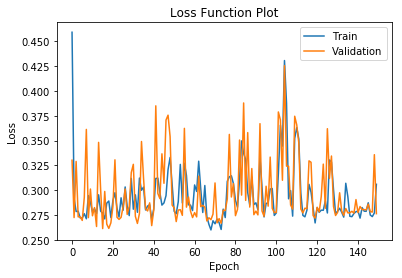

In [79]:
plt.plot(model4_history.history['loss'])
plt.plot(model4_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [80]:
train_model4_pred = mlp_model4.predict_classes(X_train)
test_model4_pred = mlp_model4.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [81]:
confusion_matrix_train = confusion_matrix(y_train, train_model4_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model4_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[29999  3053]
 [ 1500  6178]]
[[12789  1376]
 [  691  2600]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [82]:
Accuracy_Train_M4 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M4 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M4 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M4)
print("Train TPR: ",TPR_Train_M4)
print("Train Accuracy: ",Accuracy_Train_M4)

print("-----------------------")

Accuracy_Test_M4 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M4 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M4 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M4)
print("Test TPR: ",TPR_Test_M4)
print("Test Accuracy: ",Accuracy_Test_M4)

Train TNR:  0.9076304005809028
Train TPR:  0.8046366241208648
Train Accuracy:  0.8882150748833784
-----------------------
Test TNR:  0.9028591599011648
Test TPR:  0.7900334244910362
Test Accuracy:  0.8815879926672777


### MLP with 3 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons

In [83]:
np.random.seed(123)

tf.set_random_seed(123)

In [84]:
mlp_model5 = Sequential()

mlp_model5.add(Dense(25, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model5.add(Dense(20, activation='tanh', kernel_initializer='normal'))
mlp_model5.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [85]:
mlp_model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_12 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 21        
Total params: 1,091
Trainable params: 1,091
Non-trainable params: 0
_________________________________________________________________


In [86]:
mlp_model5.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [87]:
model5_history = mlp_model5.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 23us/step - loss: 0.4112 - acc: 0.8356 - val_loss: 0.3123 - val_acc: 0.8642
Epoch 2/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2920 - acc: 0.8725 - val_loss: 0.2767 - val_acc: 0.8867
Epoch 3/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2820 - acc: 0.8789 - val_loss: 0.3029 - val_acc: 0.8414
Epoch 4/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2775 - acc: 0.8790 - val_loss: 0.2855 - val_acc: 0.8615
Epoch 5/100
32584/32584 [==============================] - 1s 15us/step - loss: 0.2823 - acc: 0.8794 - val_loss: 0.2877 - val_acc: 0.8772
Epoch 6/100
32584/32584 [==============================] - 1s 15us/step - loss: 0.2796 - acc: 0.8792 - val_loss: 0.3005 - val_acc: 0.8631
Epoch 7/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2847 - acc: 0.8731 - val_loss: 0.3064 - v

32584/32584 [==============================] - 0s 15us/step - loss: 0.2823 - acc: 0.8871 - val_loss: 0.2811 - val_acc: 0.8808
Epoch 60/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2726 - acc: 0.8874 - val_loss: 0.2805 - val_acc: 0.8783
Epoch 61/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2733 - acc: 0.8828 - val_loss: 0.2730 - val_acc: 0.8861
Epoch 62/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2821 - acc: 0.8741 - val_loss: 0.2780 - val_acc: 0.8777
Epoch 63/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.3404 - acc: 0.8382 - val_loss: 0.3592 - val_acc: 0.8124
Epoch 64/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.3390 - acc: 0.8310 - val_loss: 0.3457 - val_acc: 0.8388
Epoch 65/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2862 - acc: 0.8807 - val_loss: 0.2799 - val_acc: 0.8777
Epoch 66/100
32584/32584 [==============

##### Plot

In [88]:
print(model5_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


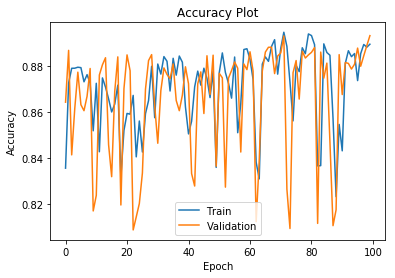

In [89]:
plt.plot(model5_history.history['acc'])
plt.plot(model5_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

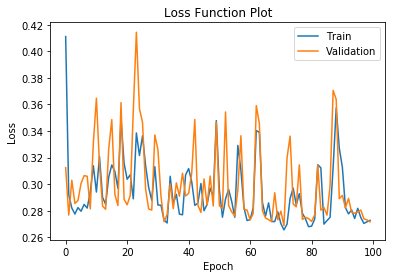

In [90]:
plt.plot(model5_history.history['loss'])
plt.plot(model5_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [91]:
train_model5_pred = mlp_model5.predict_classes(X_train)
test_model5_pred = mlp_model5.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [92]:
confusion_matrix_train = confusion_matrix(y_train, train_model5_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model5_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30968  2084]
 [ 2090  5588]]
[[13254   911]
 [  922  2369]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [93]:
Accuracy_Train_M5 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M5 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M5 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M5)
print("Train TPR: ",TPR_Train_M5)
print("Train Accuracy: ",Accuracy_Train_M5)
print("-----------------------")

Accuracy_Test_M5 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M5 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M5 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M5)
print("Test TPR: ",TPR_Test_M5)
print("Test Accuracy: ",Accuracy_Test_M5)

Train TNR:  0.9369478397676388
Train TPR:  0.7277936962750716
Train Accuracy:  0.8975202553400442
-----------------------
Test TNR:  0.9356865513589834
Test TPR:  0.7198419933151018
Test Accuracy:  0.8949931255728689


Observation:

    Based on the TPR: 2 layer mlp, with 25 nodes in hiddent layer

### MLP with 4 layers

    1st hidden layer with 25 neurons
    2nd hidden layer with 20 neurons
    3nd hidden layer with 15 neurons

In [94]:
np.random.seed(123)

tf.set_random_seed(123)

In [95]:
mlp_model6 = Sequential()

mlp_model6.add(Dense(25, input_dim=21, activation='tanh', kernel_initializer='normal'))
mlp_model6.add(Dense(20, activation='tanh', kernel_initializer='normal'))
mlp_model6.add(Dense(15, activation='tanh', kernel_initializer='normal'))
mlp_model6.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [96]:
mlp_model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_15 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_16 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 16        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


In [97]:
mlp_model6.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [98]:
model6_history = mlp_model6.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.5468 - acc: 0.8123 - val_loss: 0.4627 - val_acc: 0.8048
Epoch 2/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.3667 - acc: 0.8349 - val_loss: 0.3161 - val_acc: 0.8577
Epoch 3/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2904 - acc: 0.8774 - val_loss: 0.2982 - val_acc: 0.8813
Epoch 4/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2893 - acc: 0.8719 - val_loss: 0.3068 - val_acc: 0.8350
Epoch 5/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.2800 - acc: 0.8755 - val_loss: 0.2812 - val_acc: 0.8781
Epoch 6/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2823 - acc: 0.8783 - val_loss: 0.2786 - val_acc: 0.8872
Epoch 7/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2926 - acc: 0.8683 - val_loss: 0.3028 - v

32584/32584 [==============================] - 1s 16us/step - loss: 0.2869 - acc: 0.8757 - val_loss: 0.3111 - val_acc: 0.8380
Epoch 60/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2932 - acc: 0.8734 - val_loss: 0.3124 - val_acc: 0.8680
Epoch 61/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.2856 - acc: 0.8722 - val_loss: 0.3123 - val_acc: 0.8149
Epoch 62/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.2767 - acc: 0.8823 - val_loss: 0.2821 - val_acc: 0.8864
Epoch 63/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.3345 - acc: 0.8368 - val_loss: 0.3370 - val_acc: 0.8138
Epoch 64/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.3040 - acc: 0.8608 - val_loss: 0.3630 - val_acc: 0.8127
Epoch 65/100
32584/32584 [==============================] - 0s 15us/step - loss: 0.3389 - acc: 0.8362 - val_loss: 0.3559 - val_acc: 0.8230
Epoch 66/100
32584/32584 [==============

##### Plot

In [99]:
print(model6_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


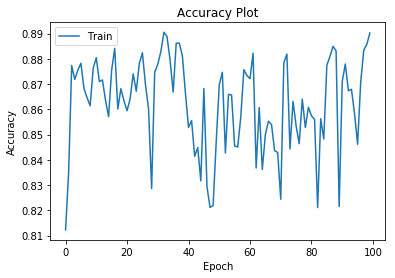

In [100]:
plt.plot(model6_history.history['acc'])
# plt.plot(model4_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

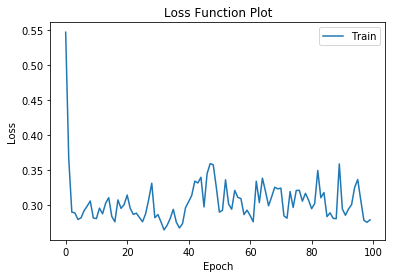

In [101]:
plt.plot(model6_history.history['loss'])
# plt.plot(model4_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [102]:
train_model6_pred = mlp_model6.predict_classes(X_train)
test_model6_pred = mlp_model6.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [103]:
confusion_matrix_train = confusion_matrix(y_train, train_model6_pred)
confusion_matrix_test = confusion_matrix(y_test, test_model6_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30750  2302]
 [ 2003  5675]]
[[13154  1011]
 [  875  2416]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [104]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)

print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9303521723345032
Train TPR:  0.7391247720760614
Train Accuracy:  0.8943039528602995
-----------------------
Test TNR:  0.9286268972820332
Test TPR:  0.7341233667578244
Test Accuracy:  0.8919569202566453


Observation:

    With respect to TPR, 2 layer mlp with 25 nodes in hidden layer is best 

## Find best parameter

#### Function for creation of model

In [105]:
def model_def(h_activation, o_activation, kernel_init):
    
    model=Sequential()
    
    model.add(Dense(25, input_dim=21, activation=h_activation, kernel_initializer=kernel_init))
    model.add(Dense(15, activation=h_activation, kernel_initializer=kernel_init))
    model.add(Dense(1, activation=o_activation, kernel_initializer=kernel_init))
    
    return model 

#### Store the best parameters

In [106]:
best_params={}

### Find the best Learning rate

    Using logarithmic scale randomly generate values between 0.0001 to 1 

In [107]:
NUM_LR = 10 

lrs = [round(i, 4) for i in list(10 ** (-4 * np.random.rand(NUM_LR)))]

lrs

[0.2703, 0.0144, 0.0214, 0.0003, 0.0002, 0.0008, 0.1425, 0.0049, 0.022, 0.1388]

In [108]:
hist_loss = []

for lr in lrs:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    lr_model = model_def(h_activation='tanh', o_activation='sigmoid', kernel_init='normal')
    
    # Compile model
    sgd = optimizers.SGD(lr=lr)
    
    lr_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit the model
    lr_model_history = lr_model.fit(X_train, y_train, validation_split=0.2, epochs=1, 
                                    shuffle=True, steps_per_epoch=50, validation_steps=50)
    
    hist_loss.append(lr_model_history.history['loss'])

Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 22ms/step - loss: 0.3833 - acc: 0.8259 - val_loss: 0.3438 - val_acc: 0.8065
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 22ms/step - loss: 0.6486 - acc: 0.7676 - val_loss: 0.6057 - val_acc: 0.8048
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 22ms/step - loss: 0.6279 - acc: 0.7809 - val_loss: 0.5686 - val_acc: 0.8048
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 23ms/step - loss: 0.6993 - acc: 0.3944 - val_loss: 0.6984 - val_acc: 0.4160
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 24ms/step - loss: 0.6998 - acc: 0.3843 - val_loss: 0.6992 - val_acc: 0.3979
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 1s 25

In [109]:
# Get the lr and loss Dataframe
loss_lr = pd.DataFrame([lrs,hist_loss]).T  

#Give the coloumn names
loss_lr.columns=['lr', 'loss']

#Sort the values and reset the index
loss_lr=loss_lr.sort_values('loss').reset_index().drop('index',axis=1)
loss_lr

,lr,loss
0,0.2703,[0.38334288120269777]
1,0.1388,[0.4278189992904663]
2,0.1425,[0.42810828030109405]
3,0.022,[0.6261799144744873]
4,0.0214,[0.62788543343544]
5,0.0144,[0.6486279726028442]
6,0.0049,[0.6805654954910278]
7,0.0008,[0.6971754848957061]
8,0.0003,[0.6993396294116974]
9,0.0002,[0.6997769665718079]


In [110]:
#pick the top lr
best_params['best_learning_rate'] = loss_lr.loc[:,'lr'][0]

#### Build model with the best learning rate

#### Got the below value as best learning rate after different experiments

In [111]:
np.random.seed(123)
tf.set_random_seed(123)

In [112]:
bst_lr_model = model_def(h_activation='tanh', o_activation='sigmoid', kernel_init='normal')

In [113]:
bst_lr_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 25)                550       
_________________________________________________________________
dense_49 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [114]:
sgd = optimizers.SGD(lr=best_params['best_learning_rate'])
bst_lr_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [115]:
bst_lr_model_history = bst_lr_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 36us/step - loss: 0.3420 - acc: 0.8284 - val_loss: 0.3448 - val_acc: 0.8065
Epoch 2/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3303 - acc: 0.8336 - val_loss: 0.3364 - val_acc: 0.8523
Epoch 3/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3353 - acc: 0.8299 - val_loss: 0.5078 - val_acc: 0.8040
Epoch 4/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3435 - acc: 0.8252 - val_loss: 0.3027 - val_acc: 0.8616
Epoch 5/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3471 - acc: 0.8218 - val_loss: 0.3550 - val_acc: 0.8096
Epoch 6/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3619 - acc: 0.8174 - val_loss: 0.3665 - val_acc: 0.8110
Epoch 7/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3365 - acc: 0.8292 - val_loss: 0.3391 - v

32584/32584 [==============================] - 1s 18us/step - loss: 0.3882 - acc: 0.8139 - val_loss: 0.3913 - val_acc: 0.8060
Epoch 60/100
32584/32584 [==============================] - 1s 16us/step - loss: 0.3865 - acc: 0.8144 - val_loss: 0.4004 - val_acc: 0.8060
Epoch 61/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3860 - acc: 0.8147 - val_loss: 0.4043 - val_acc: 0.8057
Epoch 62/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3840 - acc: 0.8153 - val_loss: 0.3859 - val_acc: 0.8128
Epoch 63/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3389 - acc: 0.8459 - val_loss: 0.3346 - val_acc: 0.8057
Epoch 64/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3238 - acc: 0.8372 - val_loss: 0.3539 - val_acc: 0.8518
Epoch 65/100
32584/32584 [==============================] - 1s 17us/step - loss: 0.3553 - acc: 0.8231 - val_loss: 0.3961 - val_acc: 0.8059
Epoch 66/100
32584/32584 [==============

##### Plot

In [116]:
print(bst_lr_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


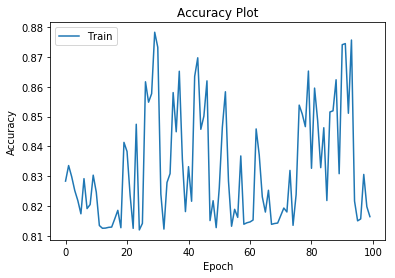

In [117]:
plt.plot(bst_lr_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

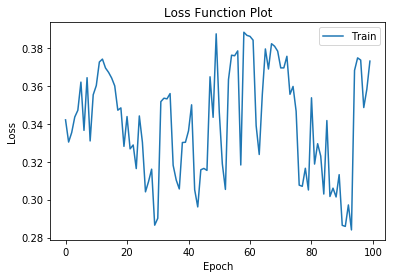

In [118]:
plt.plot(bst_lr_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [119]:
train_bst_lr_model_pred = bst_lr_model.predict_classes(X_train)
test_bst_lr_model_pred = bst_lr_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [120]:
confusion_matrix_train = confusion_matrix(y_train, train_bst_lr_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bst_lr_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32850   202]
 [ 7288   390]]
[[14057   108]
 [ 3149   142]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [121]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9938884182500303
Train TPR:  0.05079447772857515
Train Accuracy:  0.8161060643260496
-----------------------
Test TNR:  0.9923755735968938
Test TPR:  0.04314797933758736
Test Accuracy:  0.813416590284143


#### Find the best Batch size 

In [122]:
batch_sizes = [32, 64, 128, 256]

In [123]:
history=[]

for batch_size in batch_sizes:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    bs_model = model_def(h_activation='tanh', o_activation='sigmoid', kernel_init='normal')
    
     # Compile model
    sgd = optimizers.SGD(lr=best_params['best_learning_rate'])
    bs_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    #Fit the model
    bs_model_history = bs_model.fit(X_train, y_train, batch_size=batch_size, epochs=10,
                                    validation_split=0.2, shuffle=True)
    
    history.append(bs_model_history)

Train on 32584 samples, validate on 8146 samples
Epoch 1/10
32584/32584 [==============================] - 2s 53us/step - loss: 0.3341 - acc: 0.8333 - val_loss: 0.3273 - val_acc: 0.8371
Epoch 2/10
32584/32584 [==============================] - 1s 33us/step - loss: 0.3253 - acc: 0.8370 - val_loss: 0.3731 - val_acc: 0.7585
Epoch 3/10
32584/32584 [==============================] - 1s 32us/step - loss: 0.3308 - acc: 0.8300 - val_loss: 0.4002 - val_acc: 0.8121
Epoch 4/10
32584/32584 [==============================] - 1s 32us/step - loss: 0.3450 - acc: 0.8229 - val_loss: 0.4163 - val_acc: 0.8044
Epoch 5/10
32584/32584 [==============================] - 1s 32us/step - loss: 0.3496 - acc: 0.8251 - val_loss: 0.3802 - val_acc: 0.7970
Epoch 6/10
32584/32584 [==============================] - 1s 32us/step - loss: 0.3504 - acc: 0.8202 - val_loss: 0.3738 - val_acc: 0.8041
Epoch 7/10
32584/32584 [==============================] - 1s 32us/step - loss: 0.3596 - acc: 0.8148 - val_loss: 0.3661 - val_acc:

###### Summarize history for train loss

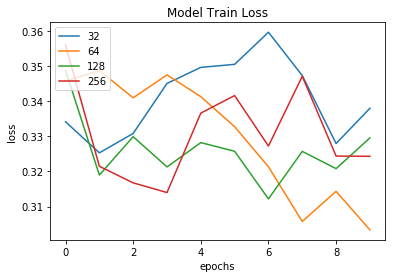

In [124]:
for i in range(0, len(history)):
    plt.plot(history[i].history['loss'])
plt.title('Model Train Loss')
plt.ylabel('loss')
plt.xlabel('epochs')  
plt.legend(batch_sizes, loc='upper left')
plt.show()

###### Summarize history for test loss

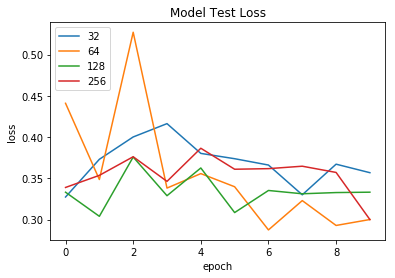

In [125]:
for i in range(0, len(history)):
    plt.plot(history[i].history['val_loss'])
plt.title('Model Test Loss')
plt.ylabel('loss')
plt.xlabel('epoch')  
plt.legend(batch_sizes, loc='upper left')
plt.show()

#### Build model with the best batch size

In [126]:
best_params['best_batch_size'] = 256

In [127]:
np.random.seed(123)
tf.set_random_seed(123)
    
bst_bs_model = model_def(h_activation='tanh', o_activation='sigmoid', kernel_init='normal')

In [128]:
sgd = optimizers.SGD(lr=best_params['best_learning_rate'])
bst_bs_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [129]:
bst_bs_model_history = bst_bs_model.fit(X_train, y_train, epochs=100, 
                                        batch_size=best_params['best_batch_size'],
                                        validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.3596 - acc: 0.8195 - val_loss: 0.3702 - val_acc: 0.7725
Epoch 2/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3187 - acc: 0.8417 - val_loss: 0.3011 - val_acc: 0.8764
Epoch 3/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3268 - acc: 0.8357 - val_loss: 0.3595 - val_acc: 0.8038
Epoch 4/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3347 - acc: 0.8284 - val_loss: 0.3000 - val_acc: 0.8710
Epoch 5/100
32584/32584 [==============================] - 0s 5us/step - loss: 0.3376 - acc: 0.8339 - val_loss: 0.3758 - val_acc: 0.8040
Epoch 6/100
32584/32584 [==============================] - 0s 5us/step - loss: 0.3438 - acc: 0.8231 - val_loss: 0.3287 - val_acc: 0.8129
Epoch 7/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3229 - acc: 0.8409 - val_loss: 0.3060 - val_acc

32584/32584 [==============================] - 0s 6us/step - loss: 0.2860 - acc: 0.8696 - val_loss: 0.2959 - val_acc: 0.8556
Epoch 61/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.2999 - acc: 0.8524 - val_loss: 0.2806 - val_acc: 0.8804
Epoch 62/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3176 - acc: 0.8384 - val_loss: 0.3157 - val_acc: 0.8206
Epoch 63/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3195 - acc: 0.8412 - val_loss: 0.3562 - val_acc: 0.8160
Epoch 64/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3436 - acc: 0.8286 - val_loss: 0.3333 - val_acc: 0.8322
Epoch 65/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.2899 - acc: 0.8766 - val_loss: 0.2899 - val_acc: 0.8769
Epoch 66/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.2852 - acc: 0.8724 - val_loss: 0.2994 - val_acc: 0.8720
Epoch 67/100
32584/32584 [=====================

##### Plot

In [130]:
print(bst_bs_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


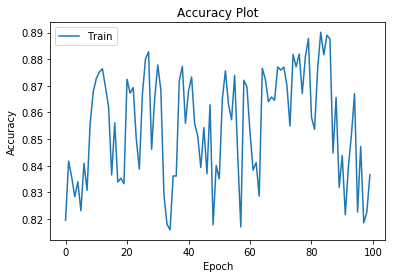

In [131]:
plt.plot(bst_bs_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

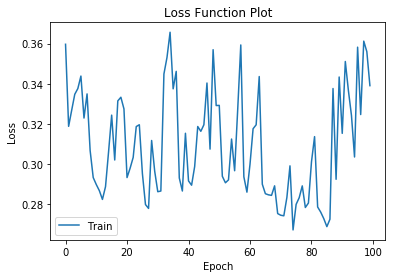

In [132]:
plt.plot(bst_bs_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [133]:
train_bst_bs_model_pred = bst_bs_model.predict_classes(X_train)
test_bst_bs_model_pred = bst_bs_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [134]:
confusion_matrix_train = confusion_matrix(y_train, train_bst_bs_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bst_bs_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[26719  6333]
 [ 1243  6435]]
[[11421  2744]
 [  592  2699]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [135]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)

print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.8083928355318891
Train TPR:  0.83810888252149
Train Accuracy:  0.8139945985759882
-----------------------
Test TNR:  0.8062830921284857
Test TPR:  0.8201154664235795
Test Accuracy:  0.8088909257561869


#### Model with Relu as activation in hidden layer,Adam optimizer,Modified Xavier

In [136]:
np.random.seed(123)
tf.set_random_seed(123)

In [137]:
relu_model= model_def(h_activation='relu',o_activation='sigmoid',kernel_init='glorot_normal')

In [138]:
relu_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [139]:
relu_model_history = relu_model.fit(X_train, y_train, epochs=100,
                                    batch_size=best_params['best_batch_size'],
                                    validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 32us/step - loss: 0.5432 - acc: 0.8561 - val_loss: 0.3898 - val_acc: 0.8807
Epoch 2/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.4034 - acc: 0.8833 - val_loss: 0.3472 - val_acc: 0.8903
Epoch 3/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3579 - acc: 0.8909 - val_loss: 0.3527 - val_acc: 0.8917
Epoch 4/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3577 - acc: 0.8912 - val_loss: 0.3574 - val_acc: 0.8890
Epoch 5/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3641 - acc: 0.8902 - val_loss: 0.3289 - val_acc: 0.8960
Epoch 6/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3415 - acc: 0.8931 - val_loss: 0.3816 - val_acc: 0.8836
Epoch 7/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.3507 - acc: 0.8944 - val_loss: 0.3468 - val_acc

32584/32584 [==============================] - 0s 6us/step - loss: 0.2641 - acc: 0.9030 - val_loss: 0.2661 - val_acc: 0.8990
Epoch 61/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.2502 - acc: 0.9051 - val_loss: 0.2681 - val_acc: 0.8991
Epoch 62/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.2578 - acc: 0.9047 - val_loss: 0.2683 - val_acc: 0.8974
Epoch 63/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.2536 - acc: 0.9053 - val_loss: 0.2682 - val_acc: 0.8974
Epoch 64/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.2657 - acc: 0.9034 - val_loss: 0.2718 - val_acc: 0.8966
Epoch 65/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.2508 - acc: 0.9058 - val_loss: 0.2694 - val_acc: 0.8977
Epoch 66/100
32584/32584 [==============================] - 0s 6us/step - loss: 0.2570 - acc: 0.9042 - val_loss: 0.2686 - val_acc: 0.8987
Epoch 67/100
32584/32584 [=====================

##### Plot

In [140]:
print(relu_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


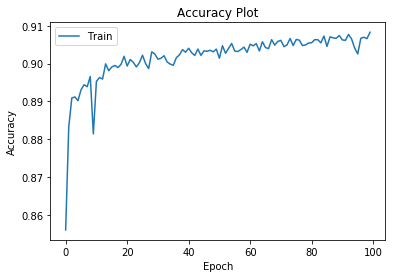

In [141]:
plt.plot(relu_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

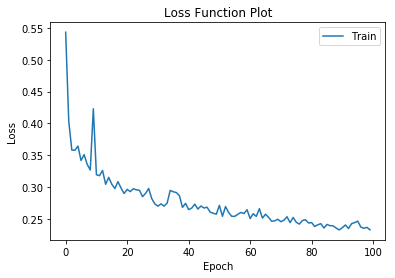

In [142]:
plt.plot(relu_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [143]:
train_relu_model_pred = relu_model.predict_classes(X_train)
test_relu_model_pred = relu_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [144]:
confusion_matrix_train = confusion_matrix(y_train, train_relu_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_relu_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31136  1916]
 [ 1907  5771]]
[[13274   891]
 [  878  2413]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [145]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.942030739440881
Train TPR:  0.7516280281323261
Train Accuracy:  0.9061379818315738
-----------------------
Test TNR:  0.9370984821743734
Test TPR:  0.7332117897295655
Test Accuracy:  0.8986594867094408


In [146]:
best_params['best_h_activation']='relu'
best_params['best_kernel_init']='glorot_normal'
best_params['best_optimizer']='adam'

#### Model with Dropout

In [147]:
np.random.seed(123)
tf.set_random_seed(123)

In [148]:
dropout_model = Sequential()
dropout_model.add(Dense(25, input_dim=21, activation='relu', kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(15, activation='relu', kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(1, activation='sigmoid',kernel_initializer="glorot_normal"))

In [149]:
dropout_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [150]:
dropout_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [151]:
dropout_model_history = dropout_model.fit(X_train, y_train, epochs=100,
                                          batch_size=best_params['best_batch_size'], 
                                          validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 1s 36us/step - loss: 1.9300 - acc: 0.7266 - val_loss: 0.6719 - val_acc: 0.8143
Epoch 2/100
32584/32584 [==============================] - 0s 7us/step - loss: 1.0343 - acc: 0.8029 - val_loss: 0.4235 - val_acc: 0.8200
Epoch 3/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.7393 - acc: 0.8124 - val_loss: 0.3840 - val_acc: 0.8117
Epoch 4/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.5917 - acc: 0.8144 - val_loss: 0.3780 - val_acc: 0.8086
Epoch 5/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.5239 - acc: 0.8157 - val_loss: 0.3766 - val_acc: 0.8062
Epoch 6/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.4687 - acc: 0.8139 - val_loss: 0.3643 - val_acc: 0.8069
Epoch 7/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.4404 - acc: 0.8138 - val_loss: 0.3624 - val_acc

32584/32584 [==============================] - 0s 7us/step - loss: 0.2926 - acc: 0.8856 - val_loss: 0.2660 - val_acc: 0.8943
Epoch 61/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.2913 - acc: 0.8849 - val_loss: 0.2650 - val_acc: 0.8968
Epoch 62/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.2907 - acc: 0.8860 - val_loss: 0.2674 - val_acc: 0.8957
Epoch 63/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.2899 - acc: 0.8850 - val_loss: 0.2665 - val_acc: 0.8968
Epoch 64/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.2894 - acc: 0.8854 - val_loss: 0.2676 - val_acc: 0.8953
Epoch 65/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.2931 - acc: 0.8866 - val_loss: 0.2696 - val_acc: 0.8939
Epoch 66/100
32584/32584 [==============================] - 0s 7us/step - loss: 0.2883 - acc: 0.8869 - val_loss: 0.2667 - val_acc: 0.8943
Epoch 67/100
32584/32584 [=====================

##### Plot

In [152]:
print(dropout_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


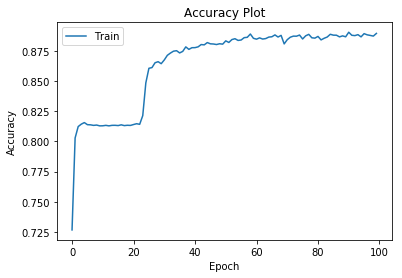

In [153]:
plt.plot(dropout_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

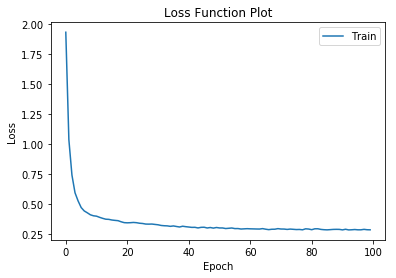

In [154]:
plt.plot(dropout_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [155]:
train_dropout_model_pred = dropout_model.predict_classes(X_train)
test_dropout_model_pred = dropout_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [156]:
confusion_matrix_train = confusion_matrix(y_train, train_dropout_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_dropout_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30819  2233]
 [ 1867  5811]]
[[13189   976]
 [  851  2440]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [157]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9324397918431563
Train TPR:  0.7568377181557697
Train Accuracy:  0.8993370979621901
-----------------------
Test TNR:  0.9310977762089657
Test TPR:  0.7414159829838954
Test Accuracy:  0.8953368469294225


#### Model with Batch Normalization

In [158]:
np.random.seed(123)
tf.set_random_seed(123)

In [159]:
bn_model = Sequential()
bn_model.add(Dense(25, input_dim=21, activation='relu', kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())
bn_model.add(Dense(15, activation='relu', kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())
bn_model.add(Dense(1, activation='sigmoid',kernel_initializer="glorot_normal"))

In [160]:
bn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 25)                550       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
dense_73 (Dense)             (None, 15)                390       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 16        
Total params: 1,116
Trainable params: 1,036
Non-trainable params: 80
_________________________________________________________________


In [161]:
bn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [162]:
bn_model_history = bn_model.fit(X_train, y_train, epochs=100,
                                batch_size=best_params['best_batch_size'], 
                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 51us/step - loss: 0.6060 - acc: 0.7566 - val_loss: 0.7499 - val_acc: 0.2293
Epoch 2/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.4373 - acc: 0.8355 - val_loss: 0.6923 - val_acc: 0.3585
Epoch 3/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.3588 - acc: 0.8511 - val_loss: 0.6321 - val_acc: 0.8079
Epoch 4/100
32584/32584 [==============================] - 0s 9us/step - loss: 0.3269 - acc: 0.8596 - val_loss: 0.6489 - val_acc: 0.6003
Epoch 5/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.3113 - acc: 0.8683 - val_loss: 0.5953 - val_acc: 0.8059
Epoch 6/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.2998 - acc: 0.8713 - val_loss: 0.5651 - val_acc: 0.8051
Epoch 7/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.2870 - acc: 0.8772 - val_loss: 0.5080 - va

Epoch 60/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.2367 - acc: 0.9000 - val_loss: 0.5221 - val_acc: 0.8049
Epoch 61/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.2370 - acc: 0.9000 - val_loss: 0.4812 - val_acc: 0.8052
Epoch 62/100
32584/32584 [==============================] - 0s 9us/step - loss: 0.2382 - acc: 0.8995 - val_loss: 0.4890 - val_acc: 0.8051
Epoch 63/100
32584/32584 [==============================] - 0s 9us/step - loss: 0.2369 - acc: 0.9004 - val_loss: 0.4791 - val_acc: 0.8053
Epoch 64/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.2368 - acc: 0.9011 - val_loss: 0.4881 - val_acc: 0.8051
Epoch 65/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.2365 - acc: 0.9008 - val_loss: 0.4781 - val_acc: 0.8053
Epoch 66/100
32584/32584 [==============================] - 0s 10us/step - loss: 0.2353 - acc: 0.9021 - val_loss: 0.4734 - val_acc: 0.8052
Epoch 67/100
32584/32584 [===

##### Plot

In [163]:
print(bn_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


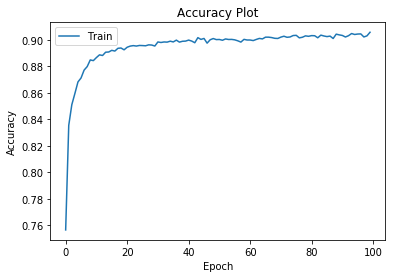

In [164]:
plt.plot(bn_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

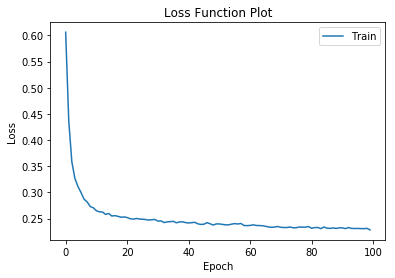

In [165]:
plt.plot(bn_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [166]:
train_bn_model_pred = bn_model.predict_classes(X_train)
test_bn_model_pred = bn_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [167]:
confusion_matrix_train = confusion_matrix(y_train, train_bn_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bn_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[33037    15]
 [ 7660    18]]
[[14157     8]
 [ 3280    11]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [168]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9995461696720319
Train TPR:  0.0023443605105496223
Train Accuracy:  0.811563957770685
-----------------------
Test TNR:  0.999435227673844
Test TPR:  0.003342449103615922
Test Accuracy:  0.8116406966086159


#### model with weight decay

#### Find the best Weight Decay value

In [169]:
weight_decay_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [170]:
def l2_model_func(l2_value):
    # create model
    l2_model = Sequential()
    
    l2_model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(l2_value), kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))
    
    # Compile model
    l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return l2_model   

In [171]:
hist_loss=[]

for weight_decay in weight_decay_list:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    l2_model = l2_model_func(weight_decay)
    
    #Fit the model
    l2_model_history = l2_model.fit(X_train, y_train, epochs=1,
                                    validation_split=0.2,steps_per_epoch=50,
                                    validation_steps=50)
    
    hist_loss.append(l2_model_history.history['loss'])

Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 2s 47ms/step - loss: 6.0264 - acc: 0.6976 - val_loss: 4.2395 - val_acc: 0.8114
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 2s 48ms/step - loss: 2.6442 - acc: 0.7033 - val_loss: 1.3378 - val_acc: 0.8132
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 2s 50ms/step - loss: 2.2894 - acc: 0.7035 - val_loss: 0.9903 - val_acc: 0.8135
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 3s 51ms/step - loss: 2.2430 - acc: 0.7030 - val_loss: 0.9228 - val_acc: 0.8132
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 3s 53ms/step - loss: 2.2404 - acc: 0.7036 - val_loss: 0.9312 - val_acc: 0.8130
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 3s 54

In [172]:
# Get the weight decay and loss Dataframe
loss_weight_decay = pd.DataFrame([weight_decay_list, hist_loss]).T  

#Give the coloumn names
loss_weight_decay.columns=['weight_decay', 'loss']

#Sort the values and reset the index
loss_weight_decay=loss_weight_decay.sort_values('loss').reset_index().drop('index',axis=1)
loss_weight_decay

,weight_decay,loss
0,1e-05,[2.2404392743110657]
1,0.0001,[2.2430016684532164]
2,1e-06,[2.2483266735076906]
3,0.001,[2.289400599002838]
4,0.01,[2.644231770038605]
5,0.1,[6.026413469314575]


In [173]:
#pick the top weight decay
best_params['best_l2_value'] = loss_weight_decay.loc[:,'weight_decay'][0]

In [174]:
best_params['best_l2_value']

1e-05

#### Build model with the best l2 value

In [175]:
np.random.seed(123)
tf.set_random_seed(123)

In [176]:
bst_l2_model = Sequential()

bst_l2_model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(best_params['best_l2_value']),kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(best_params['best_l2_value']), kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(best_params['best_l2_value']), kernel_initializer="glorot_normal"))

# Compile model
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [177]:
bst_l2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_16 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [178]:
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [179]:
bst_l2_model_history = bst_l2_model.fit(X_train, y_train, epochs=100,
                                        batch_size=best_params['best_batch_size'], 
                                        validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 57us/step - loss: 1.9384 - acc: 0.7276 - val_loss: 0.8096 - val_acc: 0.8073
Epoch 2/100
32584/32584 [==============================] - 0s 8us/step - loss: 1.0518 - acc: 0.8011 - val_loss: 0.4258 - val_acc: 0.8116
Epoch 3/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.7226 - acc: 0.8105 - val_loss: 0.3985 - val_acc: 0.8096
Epoch 4/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.5894 - acc: 0.8133 - val_loss: 0.3750 - val_acc: 0.8070
Epoch 5/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.5250 - acc: 0.8131 - val_loss: 0.3675 - val_acc: 0.8068
Epoch 6/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.4717 - acc: 0.8143 - val_loss: 0.3675 - val_acc: 0.8060
Epoch 7/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.4506 - acc: 0.8140 - val_loss: 0.3599 - val_acc

32584/32584 [==============================] - 0s 8us/step - loss: 0.2959 - acc: 0.8813 - val_loss: 0.2704 - val_acc: 0.8976
Epoch 61/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.2954 - acc: 0.8809 - val_loss: 0.2690 - val_acc: 0.8966
Epoch 62/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.2943 - acc: 0.8833 - val_loss: 0.2656 - val_acc: 0.8986
Epoch 63/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.2957 - acc: 0.8818 - val_loss: 0.2722 - val_acc: 0.8949
Epoch 64/100
32584/32584 [==============================] - 0s 9us/step - loss: 0.2943 - acc: 0.8822 - val_loss: 0.2673 - val_acc: 0.8936
Epoch 65/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.2965 - acc: 0.8822 - val_loss: 0.2655 - val_acc: 0.8965
Epoch 66/100
32584/32584 [==============================] - 0s 8us/step - loss: 0.2943 - acc: 0.8829 - val_loss: 0.2669 - val_acc: 0.8968
Epoch 67/100
32584/32584 [=====================

##### Plot

In [180]:
print(bst_l2_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


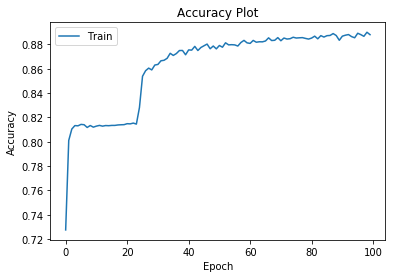

In [181]:
plt.plot(bst_l2_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

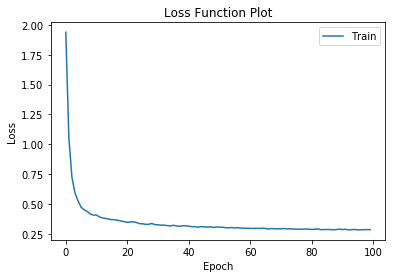

In [182]:
plt.plot(bst_l2_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [183]:
train_bst_l2_model_pred = bst_l2_model.predict_classes(X_train)
test_bst_l2_model_pred = bst_l2_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [184]:
confusion_matrix_train = confusion_matrix(y_train, train_bst_l2_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bst_l2_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30943  2109]
 [ 1915  5763]]
[[13227   938]
 [  888  2403]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [185]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)

print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9361914558876921
Train TPR:  0.7505860901276374
Train Accuracy:  0.9012030444389885
-----------------------
Test TNR:  0.9337804447582069
Test TPR:  0.7301731996353692
Test Accuracy:  0.8953941338221815


In [186]:
best_params

{'best_learning_rate': 0.2703,
 'best_batch_size': 256,
 'best_h_activation': 'relu',
 'best_kernel_init': 'glorot_normal',
 'best_optimizer': 'adam',
 'best_l2_value': 1e-05}

### Reference Links:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://keras.io/